In [1]:
import pandas as pd
from nl_causal.ts_models import _2SLS, _2SIR
from nl_causal.linear_reg import L0_IC
import numpy as np
from sklearn.preprocessing import normalize
from sim_data import sim
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform, quantile_transform
import random
from os import listdir
from os.path import isfile, join, isdir
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from os import path

In [2]:
mypath = 'path_to_data'
gene_folders = [name for name in listdir(mypath) if isdir(join(mypath, name))]

In [3]:
np.random.seed(0)
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
df = {'gene': [], 'p-value': [], 'beta': [], 'method': []}

In [ ]:
for folder_tmp in gene_folders:
    if 'July20_2SIR' not in folder_tmp:
        continue
    gene_code = folder_tmp.replace('July20_2SIR', '')
    print('\n##### Causal inference of %s #####' %gene_code)
    ## load data
    dir_name = mypath+'/'+folder_tmp
    sum_stat = pd.read_csv(dir_name+"/sum_stat.csv", sep=' ', index_col=0)
    gene_exp = -pd.read_csv(dir_name+"/gene_exp.csv", sep=' ', index_col=0)
    snp = pd.read_csv(dir_name+"/snp.csv", sep=' ', index_col=0)
    ## exclude the gene with nan in the dataset
    if sum_stat.isnull().sum().sum() + snp.isnull().sum().sum() + gene_exp.isnull().sum().sum() > 0:
        continue
    if not all(sum_stat.index == snp.columns):
        print('The cols in sum_stat are not corresponding to snps, we rename the sum_stat!')
        sum_stat.index = snp.columns

    ## n1 and n2 is pre-given
    n1, n2, p = len(gene_exp), 54162, snp.shape[1]
    LD_Z1, cov_ZX1 = np.dot(snp.values.T, snp.values), np.dot(snp.values.T, gene_exp.values.flatten())
    LD_Z2, cov_ZY2 = LD_Z1/n1*n2, sum_stat.values.flatten()*n2

    ## 2SLS
    LS = _2SLS()
    ## Stage-1 fit theta
    LS.fit_theta(LD_Z1, cov_ZX1)
    ## Stage-2 fit beta
    LS.fit_beta(LD_Z2, cov_ZY2, n2)
    ## produce p_value for beta
    LS.test_effect(n2, LD_Z2, cov_ZY2)
    print('-'*20)
    print('LS beta: %.3f' %LS.beta)
    print('p-value based on 2SLS: %.5f' %LS.p_value)
    
    ## compute R2 for the 2SLS
    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('2SLS')
    df['p-value'].append(LS.p_value)
    df['beta'].append(LS.beta)

    ## PT-2SLS
    PT_X1 = power_transform(gene_exp.values.reshape(-1,1), method='yeo-johnson').flatten()
    PT_X1 = PT_X1 - PT_X1.mean()
    PT_cor_ZX1 = np.dot(snp.values.T, PT_X1)
    PT_LS = _2SLS()
    ## Stage-1 fit theta
    PT_LS.fit_theta(LD_Z1, PT_cor_ZX1)
    ## Stage-2 fit beta
    PT_LS.fit_beta(LD_Z2, cov_ZY2, n2)
    ## produce p-value for beta
    PT_LS.test_effect(n2, LD_Z2, cov_ZY2)

    print('-'*20)
    print('PT-LS beta: %.3f' %PT_LS.beta)
    print('p-value based on PT-2SLS: %.5f' %PT_LS.p_value)

    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('PT-2SLS')
    df['p-value'].append(PT_LS.p_value)
    df['beta'].append(PT_LS.beta)

    ## 2SIR
    SIR = _2SIR(data_in_slice=0.2*n1)
    ## Stage-1 fit theta
    SIR.fit_theta(Z1=snp.values, X1=gene_exp.values.flatten())
    ## Stage-2 fit beta
    SIR.fit_beta(LD_Z2, cov_ZY2, n2)
    ## generate p-value for beta
    SIR.test_effect(n2, LD_Z2, cov_ZY2)
    print('-'*20)
    print('2SIR eigenvalues: %.3f' %SIR.sir.eigenvalues_)
    print('2SIR beta: %.3f' %SIR.beta)
    print('p-value based on 2SIR: %.5f' %SIR.p_value)
            
    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('2SIR')
    df['p-value'].append(SIR.p_value)
    df['beta'].append(SIR.beta)

    ## Comb-2SIR
    data_in_slice_lst = [.05*n1, .1*n1, .2*n1, .3*n1, .5*n1]
    comb_pvalue, comb_beta, comb_eigenvalue = [], [], []
    for data_in_slice_tmp in data_in_slice_lst:
        SIR = _2SIR(data_in_slice=data_in_slice_tmp)
        ## Stage-1 fit theta
        SIR.fit_theta(Z1=snp.values, X1=gene_exp.values.flatten())
        ## Stage-2 fit beta
        SIR.fit_beta(LD_Z2, cov_ZY2, n2)
        ## generate p-value for beta
        SIR.test_effect(n2, LD_Z2, cov_ZY2)
        comb_beta.append(SIR.beta)
        comb_pvalue.append(SIR.p_value)
        comb_eigenvalue.append(SIR.sir.eigenvalues_[0])
    comb_T = np.tan((0.5 - np.array(comb_pvalue))*np.pi).mean()
    correct_pvalue = min( max(.5 - np.arctan(comb_T)/np.pi, np.finfo(np.float64).eps), 1.0)
    print('-'*20)
    print('Comb-2SIR eigenvalues: %.3f' %np.mean(comb_eigenvalue))
    print('Comb-2SIR beta: %.3f' %np.mean(comb_beta))
    print('p-value based on Comb-2SIR: %.5f' %correct_pvalue)

    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('Comb-2SIR')
    df['p-value'].append(correct_pvalue)
    df['beta'].append(np.mean(comb_beta))

df = pd.DataFrame.from_dict(df)

In [5]:
df.sample(10)

,gene,p-value,beta,method
21690,CLPS,0.987946,0.000188,2SIR
39533,IFNA10,0.827260,-0.002878,PT-2SLS
15321,RASSF2,0.763675,0.003542,PT-2SLS
27167,USP3,0.106309,0.018060,Comb-2SIR
39426,SLC25A51,0.658329,0.005132,2SIR
38990,HLF,0.186863,0.014551,2SIR
1322,MASP2,0.377253,0.011340,2SIR
46601,SCARA5,0.149602,-0.015242,PT-2SLS
57909,EFTUD1,0.039076,-0.029672,PT-2SLS
635,MSL1,0.315792,0.013196,Comb-2SIR


## QQ-plot for p-values

In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import rv_continuous
import statsmodels.api as sm
import random
from scipy.stats import beta, chi2
from nl_causal.base.rv import neg_log_uniform

In [8]:
ci = 0.95
methods = ['2SLS', 'PT-2SLS', '2SIR']
colors = [sns.color_palette("dark")[2], sns.color_palette("dark")[0], sns.color_palette("dark")[1]]

In [9]:
all_genes = list(set(df['gene']))
num_gene = len(all_genes)

## points for CIs
low_bound = [beta.ppf((1-ci)/2, a=i, b=num_gene-i+1) for i in range(1,num_gene+1)]
up_bound = [beta.ppf((1+ci)/2, a=i, b=num_gene-i+1) for i in range(1,num_gene+1)]
ep_points = (np.arange(1,num_gene+1) - 1/2) / num_gene

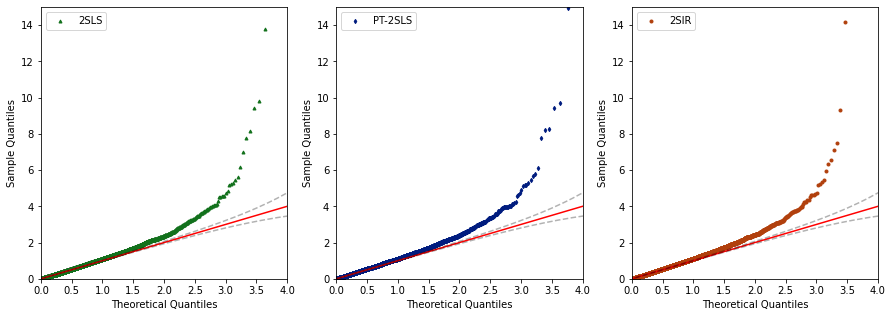

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15, 5))
for i in range(3):
    sm.qqplot(-np.log10(df[df['method'] == methods[i]]['p-value'].values), dist=neg_log_uniform(), line="45", ax=axs[i])
    axs[i].set_xlim([0,4.0])
    axs[i].set_ylim([0,15])
    axs[i].get_lines()[0].set_markersize(3.0)
    axs[i].get_lines()[0].set_markeredgecolor(colors[i])
    axs[i].get_lines()[0].set_markerfacecolor(colors[i])
    axs[i].get_lines()[0].set_markerfacecoloralt(colors[i])

axs[0].get_lines()[0].set_marker('^')
axs[1].get_lines()[0].set_marker('d')
axs[2].get_lines()[0].set_marker('o')

axs[0].get_lines()[0].set(label='2SLS')
axs[1].get_lines()[0].set(label='PT-2SLS')
axs[2].get_lines()[0].set(label='2SIR')

for i in range(3):
    axs[i].plot(-np.log10(ep_points), -np.log10(low_bound), 'k--', alpha=0.3)
    axs[i].plot(-np.log10(ep_points), -np.log10(up_bound), 'k--', alpha=0.3)
    axs[i].legend()
plt.show()

## Bar-plot for significant genes

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
gene_set = list(set(df['gene']))
num_gen = len(gene_set)
level = 0.05 / num_gen

In [14]:
# take the gene with at least one siginificant p-value
min_p = df.groupby('gene')['p-value'].min()
gene_set = list(min_p[min_p < level].index)

In [15]:
df = df[df['gene'].isin(gene_set)]
df['log-p-value'] = - np.log10( df['p-value'] )
## we only print the results for comb-2SIR
df = df[df['method'] != '2SIR']

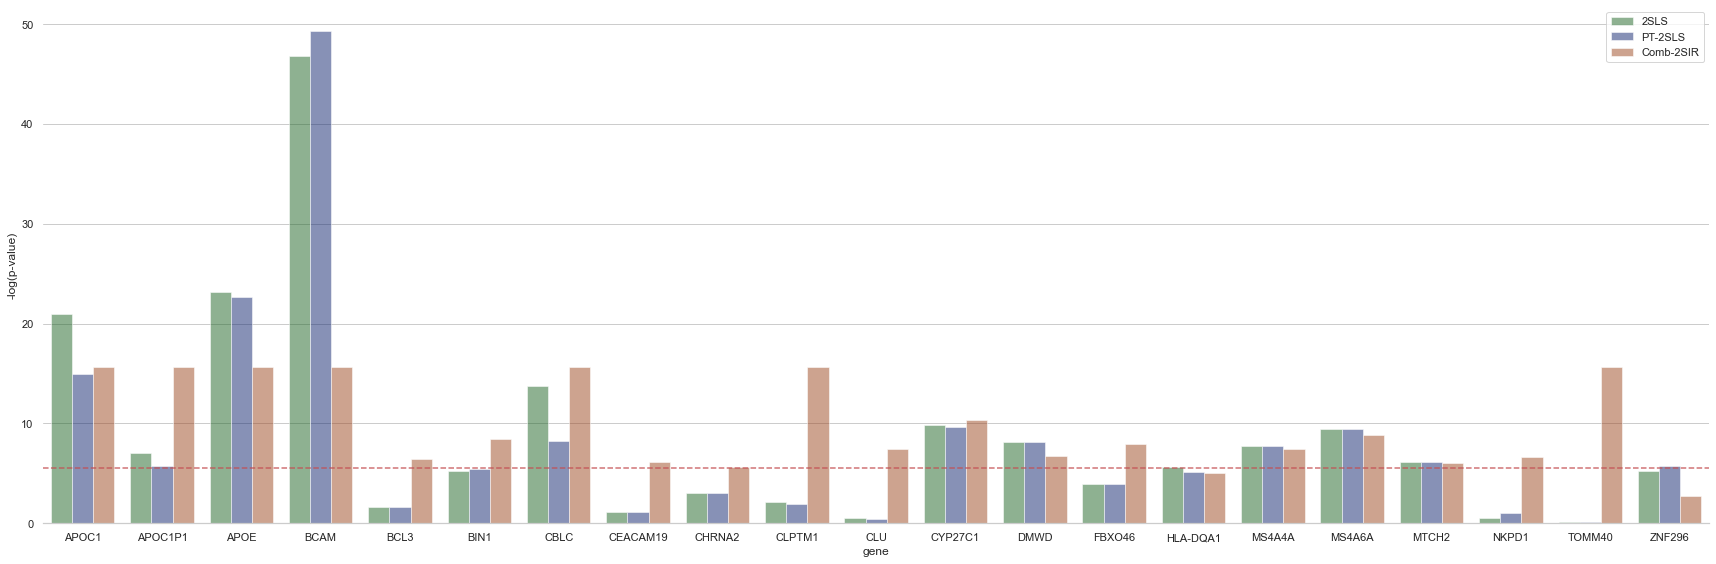

In [16]:
gene_set = set(df['gene'])
gene_set = list(gene_set)
gene_set.sort()
## plot for the final results
sns.set_theme(style="whitegrid")
# Draw a nested barplot by species and sex
plt.rcParams["figure.figsize"] = (16,6)

g = sns.catplot(
    data=df, kind="bar", order=gene_set,
    x="gene", y="log-p-value", hue="method",
    alpha=.5, height=8, legend=False, aspect=3,
    # palette='deep'
    # palette=sns.color_palette(['green', 'blue', 'orange'])
    palette = [sns.color_palette("dark")[2], sns.color_palette("dark")[0], sns.color_palette("dark")[1]]
)
plt.axhline(-np.log10(level), ls='--', color='r', alpha=.8)
g.despine(left=True)
g.set_axis_labels("gene", "-log(p-value)")
plt.legend(loc='upper right')
plt.show()